Checking required packages...
모델 파일을 선택해주세요.
이미지 파일을 선택해주세요.

[INFO] 모델 로드 중: model_CNN.h5

 Model Summary: model_CNN.h5
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 60, 80, 24)        1824      
                                                                 
 dropout_28 (Dropout)        (None, 60, 80, 24)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 30, 40, 32)        19232     
                                                                 
 dropout_29 (Dropout)        (None, 30, 40, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 15, 20, 64)        51264     
                                                                 
 dropout_30 (Dropout)        (None, 15, 20, 64)        0         

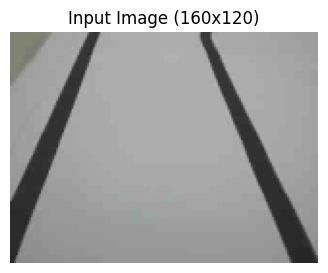


[INFO] 총 5개의 Conv2D 레이어를 시각화합니다.



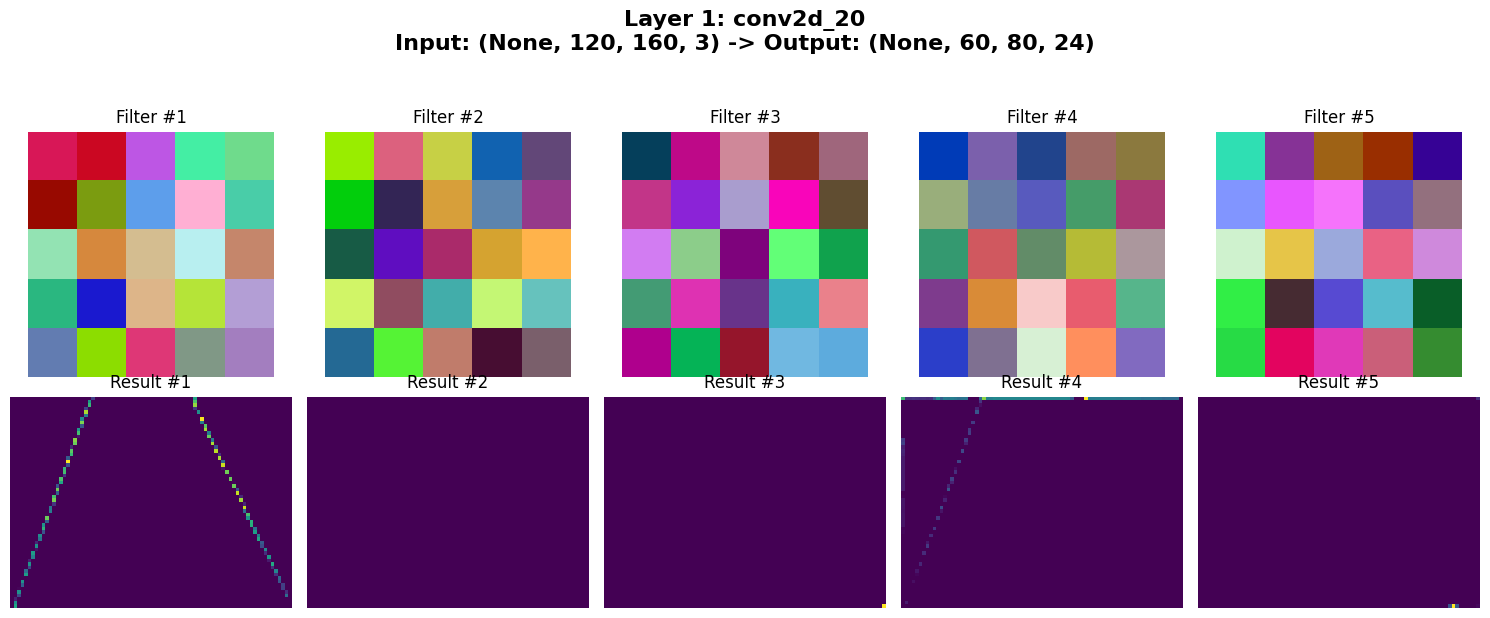

--- End of conv2d_20 ---



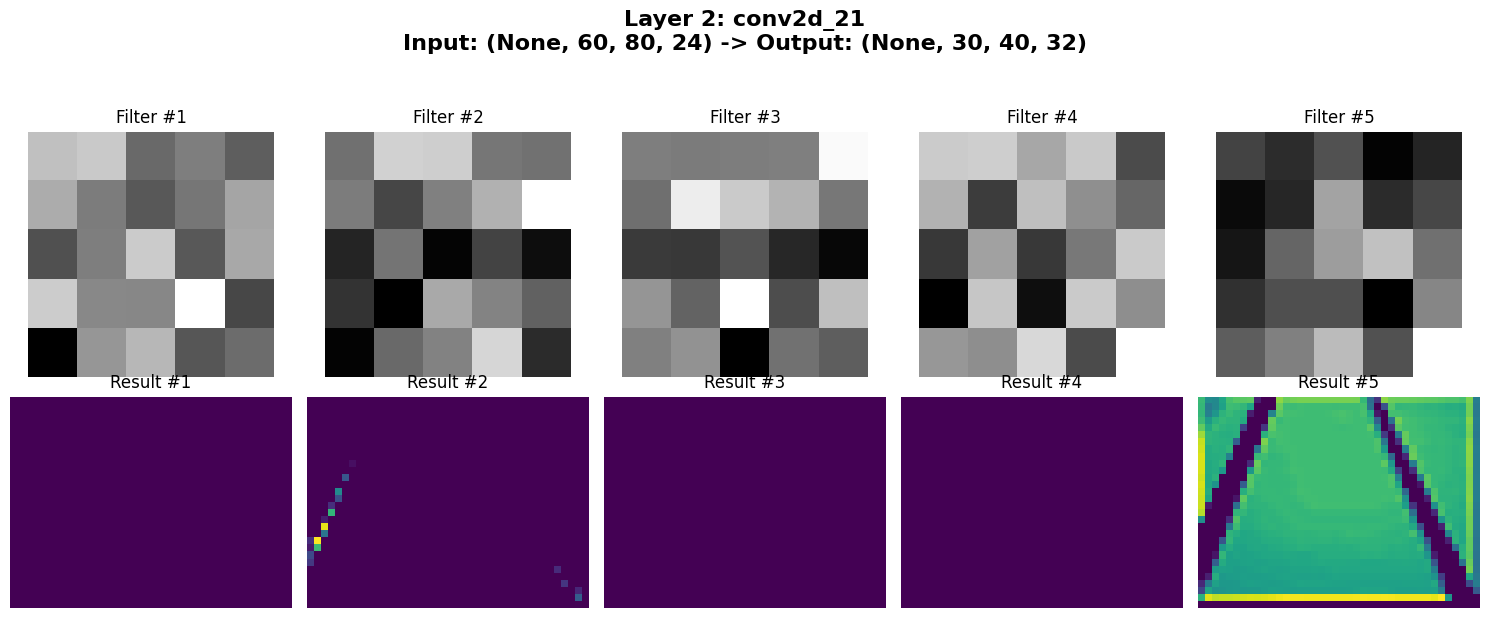

--- End of conv2d_21 ---



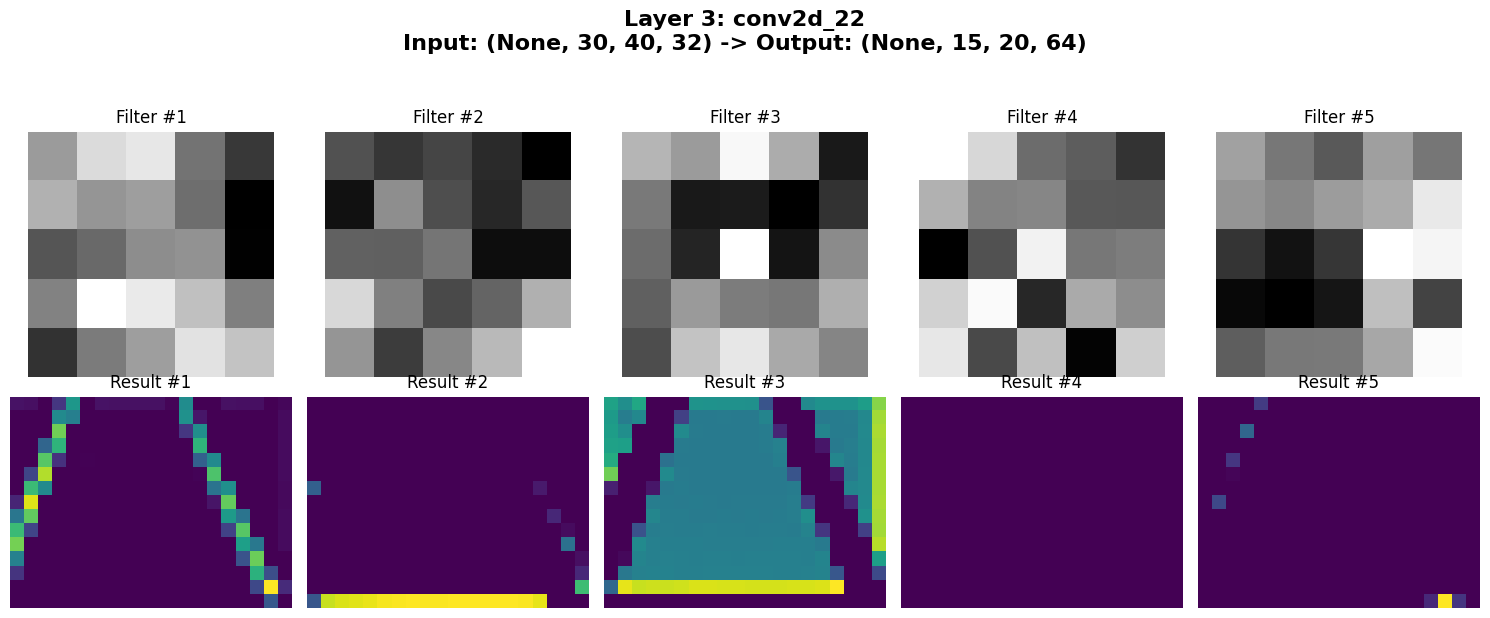

--- End of conv2d_22 ---



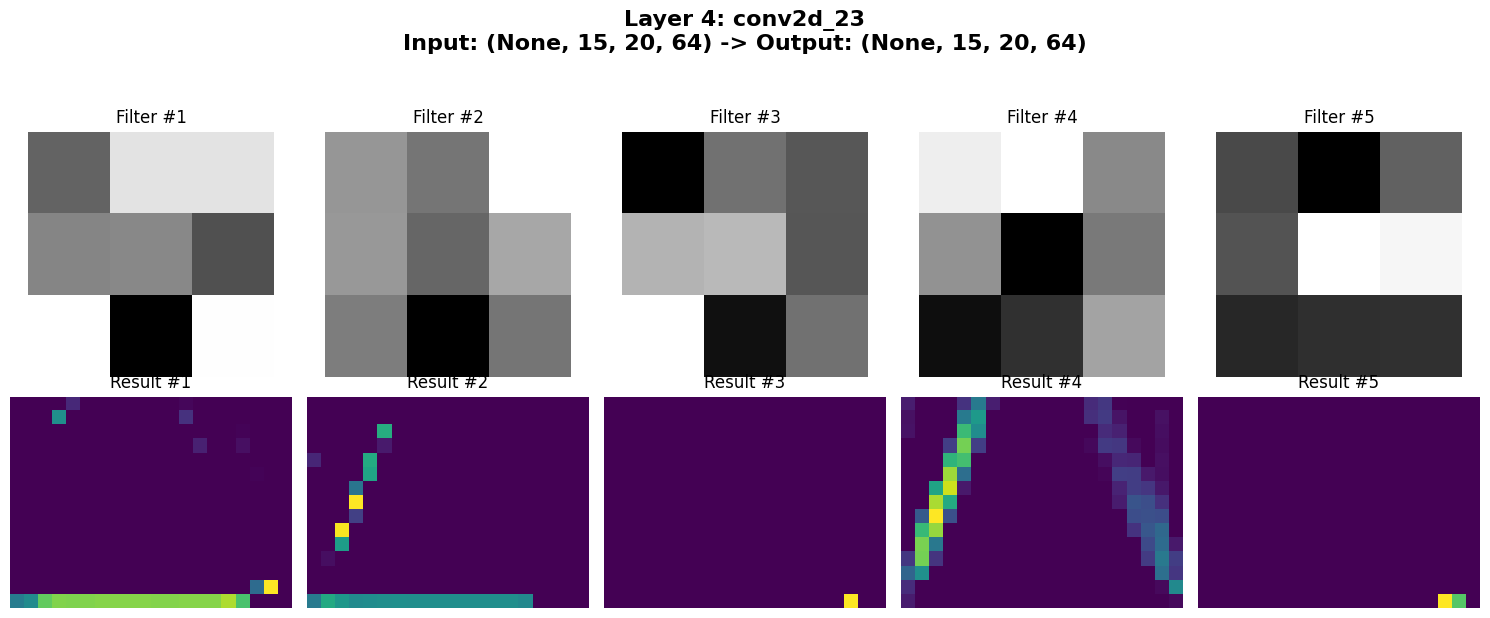

--- End of conv2d_23 ---



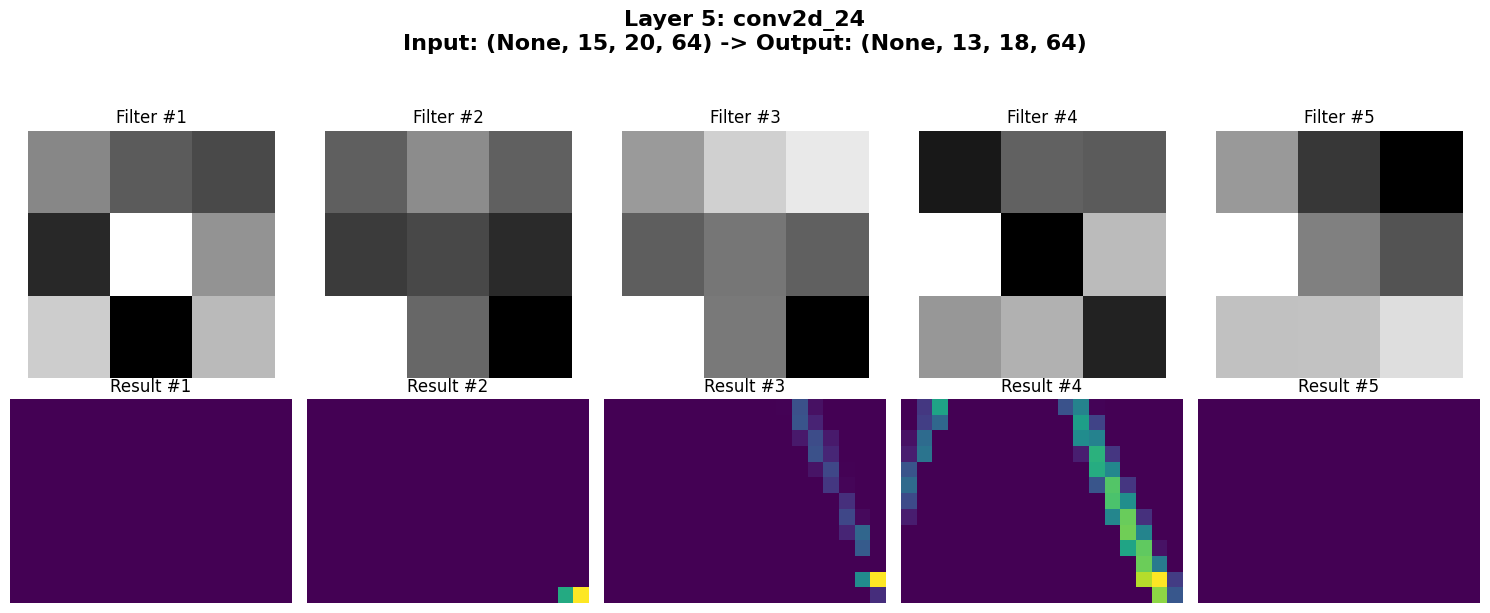

--- End of conv2d_24 ---



In [9]:
import sys
import subprocess
import importlib
import os
import tkinter as tk
from tkinter import filedialog

# ---------------------------------------------------------
# 1. 패키지 자동 설치 및 라이브러리 로드
# ---------------------------------------------------------
def install_package(module_name, package_name=None):
    if package_name is None:
        package_name = module_name
    try:
        importlib.import_module(module_name)
    except ImportError:
        print(f"Installing {package_name} ...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            print(f"{package_name} installation completed")
        except subprocess.CalledProcessError as e:
            print(f"{package_name} installation failed (exit code {e.returncode})")
            sys.exit(1)

print("Checking required packages...")
stall_package("tensorflow", "tensorflow==2.10.0")
install_package("numpy")
install_package("cv2", "opencv-python")
install_package("matplotlib")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ---------------------------------------------------------
# 2. 파일 선택
# ---------------------------------------------------------
def select_file_gui(title, filetypes):
    root = tk.Tk()
    root.withdraw() 
    root.attributes('-topmost', True)
    try:
        root.lift()
        root.focus_force()
    except:
        pass
    file_path = filedialog.askopenfilename(parent=root, title=title, filetypes=filetypes)
    root.destroy()
    return file_path

# ---------------------------------------------------------
# 3. 시각화 함수
# ---------------------------------------------------------
def visualize_cnn_layers(model_path=None, image_path=None):
    tf.keras.backend.clear_session()

    if not model_path or not os.path.exists(model_path):
        print("모델 파일을 선택해주세요.")
        model_path = select_file_gui("Select Model File (.h5)", [("H5 Files", "*.h5")])
        if not model_path: return

    if not image_path or not os.path.exists(image_path):
        print("이미지 파일을 선택해주세요.")
        image_path = select_file_gui("Select Image File", [("Images", "*.jpg;*.png;*.jpeg")])
        if not image_path: return

    # 모델 로드
    print(f"\n모델 로드 중: {os.path.basename(model_path)}")
    try:
        model = tf.keras.models.load_model(model_path)
        
        print("\n" + "="*60)
        print(f" Model Summary: {os.path.basename(model_path)}")
        print("="*60)
        model.summary()
        print("="*60 + "\n")
        
    except Exception as e:
        print(f"[ERROR] 모델 로드 실패: {e}")
        return

    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("[ERROR] 이미지를 읽을 수 없습니다.")
        return
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    target_w, target_h = 160, 120
    img_resized = cv2.resize(img_rgb, (target_w, target_h))
    
    img_tensor = img_resized.astype('float32') / 255.0
    img_tensor = np.expand_dims(img_tensor, axis=0)

    # 원본 이미지
    plt.figure(figsize=(4, 3))
    plt.imshow(img_resized)
    plt.title(f"Input Image ({target_w}x{target_h})")
    plt.axis('off')
    plt.show()

    # Feature Map
    conv_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    print(f"\n[INFO] 총 {len(conv_layers)}개의 Conv2D 레이어를 시각화합니다.\n")
    
    if len(conv_layers) == 0:
        print("시각화할 Conv2D 레이어가 없습니다.")
        return

    layer_outputs = [layer.output for layer in conv_layers]
    visualization_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    
    # 예측
    all_feature_maps = visualization_model.predict(img_tensor, verbose=0)
    
    if len(conv_layers) == 1:
        all_feature_maps = [all_feature_maps]

    # 시각화
    for i, layer in enumerate(conv_layers):
        weights = layer.get_weights()[0]
        feature_maps = all_feature_maps[i]
        
        n_filters = 5
        total_filters = weights.shape[3]
        
        fig, axes = plt.subplots(2, n_filters, figsize=(15, 6))
        layer_desc = f"Layer {i+1}: {layer.name}\nInput: {layer.input_shape} -> Output: {layer.output_shape}"
        fig.suptitle(layer_desc, fontsize=16, fontweight='bold', y=1.05)

        for j in range(n_filters):
            if j < total_filters:
                f_kernel = weights[:, :, :, j]
                

                if f_kernel.shape[2] == 3:
                    f_img = (f_kernel - f_kernel.min()) / (f_kernel.max() - f_kernel.min())
                else:
                    f_img = np.mean(f_kernel, axis=2)
                
                axes[0, j].imshow(f_img, cmap='gray')
                axes[0, j].set_title(f"Filter #{j+1}")
                axes[0, j].axis('off')

                f_map = feature_maps[0, :, :, j]
                axes[1, j].imshow(f_map, cmap='viridis')
                axes[1, j].set_title(f"Result #{j+1}")
                axes[1, j].axis('off')
            else:
                axes[0, j].axis('off')
                axes[1, j].axis('off')
        
        plt.tight_layout()
        plt.show()
        print(f"--- End of {layer.name} ---\n")

# 실행
if __name__ == "__main__":
    visualize_cnn_layers("model_CNN.h5", "test_image.jpg")